<a href="https://colab.research.google.com/github/AparnaMadva/Miscellaneous/blob/main/BertEmbeddingsExploring.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#### #1

In [ ]:
!pip install transformers[sentencepiece] datasets

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.3/6.3 MB 44.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 469.0/469.0 KB 40.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 190.3/190.3 KB 22.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.6/7.6 MB 76.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 67.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 132.0/132.0 KB 18.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 110.5/110.5 KB 17.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 213.0/213.0 KB 29.3 MB/s eta 0:00:00


In [ ]:
import torch
import torch.nn as nn
import pandas as pd

from transformers import AutoModelForSequenceClassification, AutoModel
from transformers import AutoTokenizer, AutoConfig
from transformers import DataCollatorWithPadding, Trainer, TrainingArguments
from transformers.modeling_outputs import TokenClassifierOutput
from datasets import load_dataset, Dataset, DatasetDict

In [ ]:
data = load_dataset("json",data_files="/content/Sarcasm_Headlines_Dataset.json")
data = data.rename_column('is_sarcastic','label')

data = data.remove_columns(['article_link'])
data.set_format('pandas')
data = data['train'][:]

In [ ]:
data.drop_duplicates(subset=['headline'], inplace=True)
data = data.reset_index()[['headline','label']]
data = Dataset.from_pandas(data)

In [ ]:
train_test_valid = data.train_test_split(test_size=0.2, seed=10)
test_valid = train_test_valid['test'].train_test_split(test_size=0.5, seed=10)

data = DatasetDict({
    'train': train_test_valid['train'],
    'test': test_valid['test'],
    'valid': test_valid['train']
})

In [ ]:
data

In [ ]:
checkpoint = "cardiffnlp/twitter-roberta-base-emotion"
tokenizer = AutoTokenizer.from_pretrained(checkpoint)
#tokenizer.model_max_len=512

In [ ]:
def tokenize(batch):
  return tokenizer(batch["headline"], truncation=True, max_length=512)

tokenized_dataset = data.map(tokenize, batched=True)
tokenized_dataset

In [ ]:
data_collator = DataCollatorWithPadding(tokenizer=tokenizer)

tokenized_dataset.set_format("torch", columns=['input_ids', 'attention_mask','label'])
tokenized_dataset

In [ ]:
class CustomModel(nn.Module):
  def __init__(self, checkpoint, num_labels):
    super(CustomModel, self).__init__()
    self.num_labels = num_labels

    # load model with the given checkpoint and extract its body
    self.model = model = AutoModel.from_pretrained(
        checkpoint,
        config = AutoConfig.from_pretrained(
            checkpoint,
            output_attentions = True,
            output_hidden_states = True
            )
        )
    self.dropout = nn.Dropout(0.1)
    # load and initialise weights
    self.classifier = nn.Linear(768, num_labels)

  def forward(self, input_ids=None, attention_mask=None, labels=None):
    # extract outputs from the body
    outputs = self.model(input_ids = input_ids,
                         attention_mask = attention_mask
                         )
    # add custom layers, outputs[0] = last hidden state
    sequence_output = self.dropout(outputs[0])
    # calculate losses
    logits = self.classifier(sequence_output[:,0,:].view(-1,768))

    loss = None
    if labels is not None:
      loss_fct = nn.CrossEntropyLoss()
      loss = loss_fct(logits.view(-1, self.num_labels), labels.view(-1))

    return TokenClassifierOutput(loss=loss, logits=logits, hidden_states=outputs.hidden_states, attentions=outputs.attentions)

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = CustomModel(checkpoint = checkpoint, num_labels = 2).to(device)

In [ ]:
from torch.utils.data import DataLoader

train_dataloader = DataLoader(
    tokenized_dataset['train'], shuffle=True, batch_size=32, collate_fn=data_collator
)
eval_dataloader = DataLoader(
    tokenized_dataset['valid'], shuffle=True, batch_size=32, collate_fn=data_collator
)

In [ ]:
from transformers import AdamW, get_scheduler

optimizer = AdamW(model.parameters(), lr=5e-5)

num_epochs = 3
num_training_steps = num_epochs * len(train_dataloader)
lr_scheduler = get_scheduler(
    "linear",
    optimizer = optimizer,
    num_warmup_steps = 0,
    num_training_steps = num_training_steps,
)

print(num_training_steps)

In [ ]:
from datasets import load_metric

metric = load_metric("f1")

In [ ]:
from tqdm.auto import tqdm

progress_bar_train = tqdm(range(num_training_steps))
progress_bar_eval = tqdm(range(num_epochs * len(eval_dataloader)))

for epoch in range(num_epochs):
  model.train()
  for batch in train_dataloader:
    batch = {k:v.to(device) for k,v in batch.items()}
    outputs = model(**batch)
    loss = outputs.loss
    loss.backward()

    optimizer.step()
    lr_scheduler.step()
    optimizer.zero_grad()
    progress_bar_train.update(1)

  model.eval()
  for batch in eval_dataloader:
    batch = {k:v.to(device) for k,v in batch.items()}
    with torch.no_grad():
      outputs = model(**batch)

    logits = outputs.logits
    predictions = torch.argmax(logits, dim=-1)
    metric.add_batch(predictions=predictions, references=batch['labels'])
    progress_bar_eval.update(1)

  print(metric.compute())


In [ ]:
model.eval()

test_dataloader = DataLoader(
    tokenized_dataset['test'],
    batch_size = 32,
    collate_fn = data_collator
)

In [ ]:
for batch in test_dataloader:
  batch ={k:v.to(device) for k,v in batch.items()}
  with torch.no_grad():
    outputs = model(**batch)

  logits = outputs.logits
  predictions = torch.argmax(logits, dim=-1)
  metric.add_batch(predictions = predictions, references = batch['labels'])

metric.compute()

[reference](https://towardsdatascience.com/adding-custom-layers-on-top-of-a-hugging-face-model-f1ccdfc257bd)

#### #2

In [ ]:
!pip install transformers

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
import torch
from transformers import BertModel, BertTokenizer

import logging

import matplotlib.pyplot as plt
%matplotlib inline

tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

In [ ]:
text = "This is the sample sentence for getting embeddings"
text = "[CLS]" + text + "[SEP]"

tokenized_text = tokenizer.tokenize(text)
tokenized_text

['[CLS]',
 'this',
 'is',
 'the',
 'sample',
 'sentence',
 'for',
 'getting',
 'em',
 '##bed',
 '##ding',
 '##s',
 '[SEP]']

In [ ]:
# encoded_text = tokenizer.encode(text)
# decoded_text = tokenizer.decode(encoded_text)
# decoded_text

In [ ]:
len(list(tokenizer.vocab.keys()))

30522

In [ ]:
text = "After stealing money from the bank vault, the bank robber was seen " \
       "fishing on the Mississippi river bank."
text = "[CLS]" + text + "[SEP]"

tokenized_text = tokenizer.tokenize(text)

indexed_tokens = tokenizer.convert_tokens_to_ids(tokenized_text)

for tup in zip(tokenized_text, indexed_tokens):
    print('{:<12} {:>6,}'.format(tup[0], tup[1]))

[CLS]           101
after         2,044
stealing     11,065
money         2,769
from          2,013
the           1,996
bank          2,924
vault        11,632
,             1,010
the           1,996
bank          2,924
robber       27,307
was           2,001
seen          2,464
fishing       5,645
on            2,006
the           1,996
mississippi   5,900
river         2,314
bank          2,924
.             1,012
[SEP]           102


In [ ]:
# encoded_text = tokenizer.encode(text)

# for tup in zip(tokenized_text, encoded_text):
#     print('{:<12} {:>6,}'.format(tup[0], tup[1]))

In [ ]:
segment_ids = [1] * len(tokenized_text)

segment_ids

[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]

In [ ]:
token_tensors = torch.tensor([indexed_tokens])
segment_tensors = torch.tensor([segment_ids])

In [ ]:
model = BertModel.from_pretrained('bert-base-uncased', output_hidden_states=True)

# evaluation mode turns off dropout regularization which is used in training.
model.eval()

In [ ]:
# torch.no_grad tells PyTorch not to construct the compute graph during this forward pass
# (since we won't be running backprop here) this just reduces memory consumption and speeds things up a little

with torch.no_grad():
  outputs = model(token_tensors, segment_tensors)

  hidden_states = outputs[2]

In [ ]:
print ("Number of layers:", len(hidden_states), "  (initial embeddings + 12 BERT layers)")
layer_i = 0

print ("Number of batches:", len(hidden_states[layer_i]))
batch_i = 0

print ("Number of tokens:", len(hidden_states[layer_i][batch_i]))
token_i = 0

print ("Number of hidden units:", len(hidden_states[layer_i][batch_i][token_i]))

Number of layers: 13   (initial embeddings + 12 BERT layers)
Number of batches: 1
Number of tokens: 22
Number of hidden units: 768


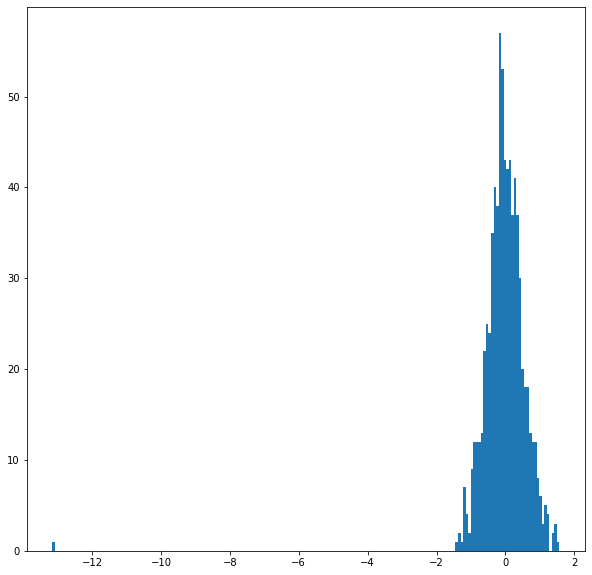

In [ ]:
# For the 5th token in our sentence, select its feature values from layer 5.
token_i = 5
layer_i = 5
vec = hidden_states[layer_i][batch_i][token_i]  # Plot the values as a histogram to show their distribution.
plt.figure(figsize=(10,10))
plt.hist(vec, bins=200)
plt.show()

In [ ]:
# Current dimensions: [# layers, # batches, # tokens, # features]
# Desired dimensions: [# tokens, # layers, # features]

# `hidden_states` is a Python list.
print('      Type of hidden_states: ', type(hidden_states))

# Each layer in the list is a torch tensor.
print('Tensor shape for each layer: ', hidden_states[0].size())

      Type of hidden_states:  <class 'tuple'>
Tensor shape for each layer:  torch.Size([1, 22, 768])


In [ ]:
# Concatenate the tensors for all layers. We use `stack` here to
# create a new dimension in the tensor.
token_embeddings = torch.stack(hidden_states, dim=0)

token_embeddings.size()

torch.Size([13, 1, 22, 768])

In [ ]:
# Remove dimension 1, the "batches".
token_embeddings = torch.squeeze(token_embeddings, dim=1)

token_embeddings.size()

torch.Size([13, 22, 768])

In [ ]:
# Swap dimensions 0 and 1.
token_embeddings = token_embeddings.permute(1,0,2)

token_embeddings.size()

torch.Size([22, 13, 768])

creating word and sentence embeddings

In [ ]:
token_vecs_cat = []

for token in token_embeddings:
  cat_vec = torch.cat((token[-1], token[-2], token[-3], token[-4]), dim=0)

  token_vecs_cat.append(cat_vec)

print('Shape is: %d x %d' % (len(token_vecs_cat), len(token_vecs_cat[0])))

Shape is: 22 x 3072


In [ ]:
token_vecs_sum = []

for token in token_embeddings:
  sum_vec = torch.sum(token[-4:], dim=0)

  token_vecs_sum.append(sum_vec)

print('Shape is: %d x %d' % (len(token_vecs_sum), len(token_vecs_sum[0])))

Shape is: 22 x 768


In [ ]:
# `hidden_states` has shape [13 x 1 x 22 x 768]
# `token_vecs` is a tensor with shape [22 x 768]

token_vecs = hidden_states[-2][0]

sentence_embedding = torch.mean(token_vecs, dim=0)

In [ ]:
print("final sentence embedding vector of shape:", sentence_embedding.size())

final sentence embedding vector of shape: torch.Size([768])


In [ ]:
for i, token_str in enumerate(tokenized_text):
  print (i, token_str)

0 [CLS]
1 after
2 stealing
3 money
4 from
5 the
6 bank
7 vault
8 ,
9 the
10 bank
11 robber
12 was
13 seen
14 fishing
15 on
16 the
17 mississippi
18 river
19 bank
20 .
21 [SEP]


In [ ]:
print('first 5 vector values for each instance of "bank".')
print('')
print("bank vault ", str(token_vecs_sum[6][:5]))
print("bank robber ", str(token_vecs_sum[10][:5]))
print("river bank ", str(token_vecs_sum[19][:5]))

first 5 vector values for each instance of "bank".

bank vault  tensor([ 3.3596, -2.9805, -1.5421,  0.7065,  2.0031])
bank robber  tensor([ 2.7359, -2.5577, -1.3094,  0.6797,  1.6633])
river bank  tensor([ 1.5266, -0.8895, -0.5152, -0.9298,  2.8334])


In [ ]:
from scipy.spatial.distance import cosine

diff_bank = 1 - cosine(token_vecs_sum[10], token_vecs_sum[19])

same_bank = 1 - cosine(token_vecs_sum[10], token_vecs_sum[6])

print("vector similarity for *similar* meanings: %.2f" % same_bank)
print("vector similarity for *different* meanings: %.2f" % diff_bank)

vector similarity for *similar* meanings: 0.94
vector similarity for *different* meanings: 0.69


[reference](http://mccormickml.com/2019/05/14/BERT-word-embeddings-tutorial/)